In [1]:
import os
import zarr
import timm
import random
import json
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict
import sys
import torch
from torch.cuda.amp import autocast, GradScaler

# import torchvision.transforms.functional as F
import random

warnings.filterwarnings("ignore")
sys.path.append("./src/")

from src.config import CFG
from src.dataloader import (
    read_zarr,
    read_info_json,
    scale_coordinates,
    create_dataset,
    create_segmentation_map,
    EziiDataset,
    drop_padding,
)
from src.network import Unet3D
from src.utils import save_images, PadToSize
from src.metric import (
    score,
    create_cls_pos,
    create_cls_pos_sikii,
    create_df,
    SegmentationLoss,
    DiceLoss,
)
from src.inference import inference, inference2pos, create_gt_df
from metric import visualize_epoch_results

In [2]:
train_dataset = EziiDataset(
    exp_names=CFG.train_exp_names,
    base_dir="../../inputs/train/",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.train_zarr_types,
    train=True,
    augmentation=True,
    slice=True,
    pre_read=True,
)

# train_nshuffle_dataset = EziiDataset(
#     exp_names=CFG.train_exp_names,
#     base_dir="../../inputs/train/",
#     particles_name=CFG.particles_name,
#     resolution=CFG.resolution,
#     zarr_type=CFG.train_zarr_types,
#     augmentation=False,
#     train=True,
# )

valid_dataset = EziiDataset(
    exp_names=CFG.valid_exp_names,
    base_dir="../../inputs/train/",
    particles_name=CFG.particles_name,
    resolution=CFG.resolution,
    zarr_type=CFG.valid_zarr_types,
    augmentation=False,
    train=True,
    slice=True,
    pre_read=True,
)

from tqdm import tqdm

train_loader = DataLoader(
    train_dataset,
    batch_size=CFG.batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=CFG.num_workers,
)
# train_nshuffle_loader = DataLoader(
#     train_nshuffle_dataset,
#     batch_size=1,
#     shuffle=True,
#     drop_last=True,
#     pin_memory=True,
#     num_workers=CFG.num_workers,
# )
valid_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    pin_memory=True,
    num_workers=CFG.num_workers,
)

for data in tqdm(train_loader):
    normalized_tomogram = data["normalized_tomogram"]
    segmentation_map = data["segmentation_map"]
    break

normalized_tomogram.shape

  0%|          | 0/300 [00:01<?, ?it/s]


torch.Size([4, 16, 64, 64])

In [3]:
train_dataset[0]["segmentation_map"].shape

(16, 64, 64)

In [4]:
encoder = timm.create_model(
    model_name=CFG.model_name,
    pretrained=True,
    in_chans=3,
    num_classes=0,
    global_pool="",
    features_only=True,
)
model = Unet3D(encoder=encoder).to("cuda")
# model.load_state_dict(torch.load("./pretrained_model.pth"))
# model.load_state_dict(torch.load("./best_model.pth"))

In [5]:
# input-test

x = torch.randn(2, 16, 1, 64, 64).cuda()
model(x).shape

torch.Size([2, 7, 16, 64, 64])

In [6]:
# # "encoder"と名のつくパラメータは学習しない
# for layer, param in model.named_parameters():
#     if "encoder" in layer:
#         param.requires_grad = False

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# サンプルデータ
num_classes = len(CFG.particles_name)  # クラス数
colors = plt.cm.tab10(
    np.arange(len(CFG.particles_name))
)  # "tab10" カラーマップから色を取得

# ListedColormap を作成
class_colormap = ListedColormap(colors)


# カラーバー付きプロット
def plot_with_colormap(data, title, original_tomogram):
    masked_data = np.ma.masked_where(data <= 0, data)  # クラス0をマスク
    plt.imshow(original_tomogram, cmap="gray")
    im = plt.imshow(masked_data, cmap=class_colormap)
    plt.title(title)
    plt.axis("off")
    return im

In [8]:
import torch
import random
import torchvision.transforms.functional as TF


# 回転
# 3Dテンソルの各軸に対して指定した角度で回転する関数
def rotate_3d(tomogram, segmentation_map, angle):
    """Rotates the 3D tensors tomogram and segmentation_map around the Z-axis."""
    rotated_tomogram = TF.rotate(tomogram, angle, expand=False)
    rotated_segmentation_map = TF.rotate(segmentation_map, angle, expand=False)
    return rotated_tomogram, rotated_segmentation_map


# 平行移動
# 指定された範囲でランダムに平行移動
def translate_3d(tomogram, segmentation_map, max_shift):
    """Translates the 3D tensors by a random shift within max_shift."""
    shift_x = random.randint(-max_shift, max_shift)
    shift_y = random.randint(-max_shift, max_shift)
    translated_tomogram = TF.affine(
        tomogram, angle=0, translate=(shift_x, shift_y), scale=1, shear=0
    )
    translated_segmentation_map = TF.affine(
        segmentation_map, angle=0, translate=(shift_x, shift_y), scale=1, shear=0
    )
    return translated_tomogram, translated_segmentation_map


# フリップ
# 縦横（上下左右）ランダムフリップ
def flip_3d(tomogram, segmentation_map):
    """Randomly flips the 3D tensors along height or width."""
    if random.random() > 0.5:  # Horizontal flip
        tomogram = torch.flip(tomogram, dims=[-1])
        segmentation_map = torch.flip(segmentation_map, dims=[-1])
    if random.random() > 0.5:  # Vertical flip
        tomogram = torch.flip(tomogram, dims=[-2])
        segmentation_map = torch.flip(segmentation_map, dims=[-2])
    return tomogram, segmentation_map


# クロッピング
# 入力テンソルを中心またはランダムクロップで切り取る
def crop_3d(tomogram, segmentation_map, crop_size):
    """Crops the 3D tensors to the specified crop_size."""
    _, depth, height, width = tomogram.size()
    crop_d, crop_h, crop_w = crop_size

    if crop_h > height or crop_w > width:
        raise ValueError("Crop size cannot be larger than the original size.")

    start_h = random.randint(0, height - crop_h)  # Random starting position for height
    start_w = random.randint(0, width - crop_w)  # Random starting position for width

    cropped_tomogram = tomogram[
        :, :, start_h : start_h + crop_h, start_w : start_w + crop_w
    ]
    cropped_segmentation_map = segmentation_map[
        :, :, start_h : start_h + crop_h, start_w : start_w + crop_w
    ]

    return cropped_tomogram, cropped_segmentation_map


# Mixup
# 2つのサンプルを線形補間して混合
def mixup(tomogram, segmentation_map, alpha=0.4):
    """Applies mixup augmentation to the batch."""
    lam = random.betavariate(alpha, alpha)
    batch_size = tomogram.size(0)
    index = torch.randperm(batch_size)

    mixed_tomogram = lam * tomogram + (1 - lam) * tomogram[index, :]
    mixed_segmentation_map = (
        lam * segmentation_map + (1 - lam) * segmentation_map[index, :]
    )

    return mixed_tomogram, mixed_segmentation_map


# Cutmix
# ランダム領域を切り取って別のサンプルに貼り付け
def cutmix(tomogram, segmentation_map, alpha=1.0):
    """Applies cutmix augmentation to the batch."""
    lam = random.betavariate(alpha, alpha)
    batch_size, depth, height, width = tomogram.size()
    index = torch.randperm(batch_size)

    cx = random.randint(0, width)
    cy = random.randint(0, height)
    cw = int(width * (1 - lam))
    ch = int(height * (1 - lam))

    x1 = max(cx - cw // 2, 0)
    x2 = min(cx + cw // 2, width)
    y1 = max(cy - ch // 2, 0)
    y2 = min(cy + ch // 2, height)

    tomogram[:, :, y1:y2, x1:x2] = tomogram[index, :, y1:y2, x1:x2]
    segmentation_map[:, :, y1:y2, x1:x2] = segmentation_map[index, :, y1:y2, x1:x2]

    return tomogram, segmentation_map


# データ拡張の組み合わせ適用
def augment_data(
    tomogram,
    segmentation_map,
    crop_size=(16, 12, 12),
    max_shift=10,
    rotation_angle=30,
    p=0.5,
    mixup_alpha=0.4,
    cutmix_alpha=1.0,
):
    """Applies a combination of rotation, translation, flipping, cropping, mixup, and cutmix to the inputs with probabilities."""
    if random.random() < p:
        tomogram, segmentation_map = rotate_3d(
            tomogram,
            segmentation_map,
            angle=random.uniform(-rotation_angle, rotation_angle),
        )
    if random.random() < p:
        tomogram, segmentation_map = translate_3d(
            tomogram, segmentation_map, max_shift=max_shift
        )
    if random.random() < p:
        tomogram, segmentation_map = flip_3d(tomogram, segmentation_map)
    if random.random() < p:
        tomogram, segmentation_map = crop_3d(
            tomogram, segmentation_map, crop_size=crop_size
        )
    if random.random() < p:
        tomogram, segmentation_map = mixup(
            tomogram, segmentation_map, alpha=mixup_alpha
        )
    # if random.random() < p:
    #     tomogram, segmentation_map = cutmix(
    #         tomogram, segmentation_map, alpha=cutmix_alpha
    #     )
    return tomogram, segmentation_map


# 使用例
# バッチサイズ6, 深さ16, 高さ320, 幅320のランダムテンソル
tomogram = torch.rand((6, 16, 320, 320))
segmentation_map = torch.randint(0, 2, (6, 16, 320, 320))  # ラベルは0または1

# データ拡張の適用
aug_tomogram, aug_segmentation_map = augment_data(tomogram, segmentation_map, p=0.7)
print("Original shape:", tomogram.shape)
print("Augmented shape:", aug_tomogram.shape)

Original shape: torch.Size([6, 16, 320, 320])
Augmented shape: torch.Size([6, 16, 12, 12])


In [9]:
from transformers import get_cosine_schedule_with_warmup

optimizer = torch.optim.Adam(
    model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay
)
criterion = nn.CrossEntropyLoss(
    #  weight=torch.tensor([2.0, 32, 32, 32, 32, 32, 32]).to("cuda")
)
# criterion = DiceLoss()
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=10,
    num_training_steps=CFG.epochs * len(train_loader),
    # * batch_size,
)
scaler = GradScaler()
seg_loss = SegmentationLoss(criterion)
padf = PadToSize(CFG.resolution)

In [10]:
# b, c, d, h, w = CFG.batch_size, 1, 96, 320, 320

In [11]:
def preprocess_tensor(tensor):
    batch_size, depth, height, width = tensor.shape
    tensor = tensor.unsqueeze(2)  # (b, d, h, w) -> (b, d, 1, h, w)
    return tensor

In [12]:
padf = PadToSize(CFG.resolution)
padf(normalized_tomogram).shape

torch.Size([4, 16, 64, 64])

In [13]:
# best_model = None
# best_score = -100

# grand_train_loss = []
# grand_valid_loss = []
# grand_train_score = []
# grand_valid_score = []

# for epoch in range(CFG.epochs):
#     model.train()
#     train_loss = []
#     valid_loss = []
#     with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{CFG.epochs} [Training]") as tq:
#         for data in tq:
#             normalized_tomogram = data["normalized_tomogram"]
#             segmentation_map = data["segmentation_map"]

#             # normalized_tomogram = padf(normalized_tomogram)
#             # segmentation_map = padf(segmentation_map)

#             # データ拡張
#             # normalized_tomogram, segmentation_map = augment_data(
#             #     normalized_tomogram, segmentation_map, p=CFG.augmentation_prob
#             # )
#             normalized_tomogram = normalized_tomogram.cuda()
#             segmentation_map = segmentation_map.long().cuda()

#             optimizer.zero_grad()

#             with autocast():
#                 pred = model(preprocess_tensor(normalized_tomogram))
#                 loss = seg_loss(pred, segmentation_map)
#             # loss.backward()
#             # optimizer.step()
#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()
#             scheduler.step()
#             train_loss.append(loss.item())

#             # 確率予測
#             prob_pred = torch.softmax(pred, dim=1)
#             tq.set_postfix({"loss": f"{np.mean(train_loss):.4f}"})

#     with tqdm(valid_loader, desc=f"Epoch {epoch + 1}/{CFG.epochs} [Validation]") as tq:
#         for data in tq:
#             normalized_tomogram = data["normalized_tomogram"].cuda()
#             segmentation_map = data["segmentation_map"].long().cuda()

#             # normalized_tomogram = padf(normalized_tomogram)
#             # segmentation_map = padf(segmentation_map)

#             with autocast():
#                 pred = model(preprocess_tensor(normalized_tomogram))
#                 loss = seg_loss(pred, segmentation_map)
#             valid_loss.append(loss.item())

#             # 確率予測
#             prob_pred = torch.softmax(pred, dim=1)
#             tq.set_postfix({"loss": f"{np.mean(valid_loss):.4f}"})

#     # # ############### validation ################
#     train_nshuffle_original_tomogram = defaultdict(list)
#     train_nshuffle_pred_tomogram = defaultdict(list)
#     train_nshuffle_gt_tomogram = defaultdict(list)

#     valid_original_tomogram = defaultdict(list)
#     valid_pred_tomogram = defaultdict(list)
#     valid_gt_tomogram = defaultdict(list)

#     train_mean_scores = []
#     valid_mean_scores = []

#     # モデルの保存
#     torch.save(model.state_dict(), "./pretrained_model.pth")

#     # ############### validation ################
#     train_nshuffle_original_tomogram = defaultdict(list)
#     train_nshuffle_pred_tomogram = defaultdict(list)
#     train_nshuffle_gt_tomogram = defaultdict(list)

#     valid_original_tomogram = defaultdict(list)
#     valid_pred_tomogram = defaultdict(list)
#     valid_gt_tomogram = defaultdict(list)

#     train_mean_scores = []
#     valid_mean_scores = []

#     # for exp_name in tqdm(CFG.train_exp_names):
#     for exp_name in CFG.train_exp_names[:5]:  # 5つのデータで試す
#         # inferenced_array = inference(model, exp_name, train=False)
#         inferenced_array, n_tomogram, segmentation_map = inference(
#             model, exp_name, train=True
#         )

#         constant = 0.5
#         sikii = {
#             "apo-ferritin": constant,
#             "beta-amylase": constant,
#             "beta-galactosidase": constant,
#             "ribosome": constant,
#             "thyroglobulin": constant,
#             "virus-like-particle": constant,
#         }

#         pred_df = inference2pos(
#             pred_segmask=inferenced_array, exp_name=exp_name, sikii_dict=sikii
#         )
#         base_dir = "../../inputs/train/overlay/ExperimentRuns/"
#         gt_df = create_gt_df(base_dir, [exp_name])

#         train_nshuffle_pred_tomogram[exp_name] = inferenced_array

#         if len(pred_df) != 0:
#             score_ = score(
#                 pred_df,
#                 gt_df,
#                 row_id_column_name="index",
#                 distance_multiplier=1.0,
#                 beta=4,
#             )
#             train_mean_scores.append(score_)

#         del inferenced_array, n_tomogram, segmentation_map
#         import gc
#         import torch.cuda as cuda

#         gc.collect()
#         cuda.empty_cache()

#     # print("train_mean_scores", np.mean(train_mean_scores))

#     for exp_name in CFG.valid_exp_names:
#         inferenced_array, n_tomogram, segmentation_map = inference(
#             model, exp_name, train=True
#         )
#         pred_df = inference2pos(
#             pred_segmask=inferenced_array, exp_name=exp_name, sikii_dict=sikii
#         )
#         base_dir = "../../inputs/train/overlay/ExperimentRuns/"
#         gt_df = create_gt_df(base_dir, [exp_name])

#         valid_pred_tomogram[exp_name] = inferenced_array

#         if len(pred_df) != 0:
#             score_ = score(
#                 pred_df,
#                 gt_df,
#                 row_id_column_name="index",
#                 distance_multiplier=1.0,
#                 beta=4,
#             )
#             valid_mean_scores.append(score_)

#         del inferenced_array, n_tomogram, segmentation_map
#         import gc
#         import torch.cuda as cuda

#         gc.collect()
#         cuda.empty_cache()
#     # print("valid_mean_scores", np.mean(valid_mean_scores))

#     if np.mean(valid_mean_scores) > best_score:
#         best_score = np.mean(valid_mean_scores)
#         best_model = model.state_dict()
#         torch.save(best_model, f"./best_model.pth")

#     print(
#         f"train-epoch-loss:{np.mean(train_loss):.4f}",
#         f"valid-epoch-loss:{np.mean(valid_loss):.4f}",
#         f"train-beta4-score:{np.mean(train_mean_scores):.4f}",
#         f"valid-beta4-score:{np.mean(valid_mean_scores):.4f}",
#     )

#     grand_train_loss.append(np.mean(train_loss))
#     grand_valid_loss.append(np.mean(valid_loss))
#     grand_train_score.append(np.mean(train_mean_scores))
#     grand_valid_score.append(np.mean(valid_mean_scores))

In [14]:
best_model = None
best_constant = 0
best_score = -100

grand_train_loss = []
grand_valid_loss = []
grand_train_score = []
grand_valid_score = []

for epoch in range(CFG.epochs):
    model.train()
    train_loss = []
    valid_loss = []
    with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{CFG.epochs} [Training]") as tq:
        for data in tq:
            normalized_tomogram = data["normalized_tomogram"]
            segmentation_map = data["segmentation_map"]

            normalized_tomogram = padf(normalized_tomogram)
            segmentation_map = padf(segmentation_map)

            # データ拡張
            # normalized_tomogram, segmentation_map = augment_data(
            #     normalized_tomogram, segmentation_map, p=CFG.augmentation_prob
            # )
            normalized_tomogram = normalized_tomogram.cuda()
            segmentation_map = segmentation_map.long().cuda()

            optimizer.zero_grad()

            with autocast():
                pred = model(preprocess_tensor(normalized_tomogram))
                loss = seg_loss(pred, segmentation_map)
            # loss.backward()
            # optimizer.step()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            train_loss.append(loss.item())

            # 確率予測
            prob_pred = torch.softmax(pred, dim=1)
            tq.set_postfix({"loss": f"{np.mean(train_loss):.4f}"})

    with tqdm(valid_loader, desc=f"Epoch {epoch + 1}/{CFG.epochs} [Validation]") as tq:
        for data in tq:
            normalized_tomogram = data["normalized_tomogram"].cuda()
            segmentation_map = data["segmentation_map"].long().cuda()

            normalized_tomogram = padf(normalized_tomogram)
            segmentation_map = padf(segmentation_map)

            with autocast():
                pred = model(preprocess_tensor(normalized_tomogram))
                loss = seg_loss(pred, segmentation_map)
            valid_loss.append(loss.item())

            # 確率予測
            prob_pred = torch.softmax(pred, dim=1)
            tq.set_postfix({"loss": f"{np.mean(valid_loss):.4f}"})

    # # ############### validation ################
    train_nshuffle_original_tomogram = defaultdict(list)
    train_nshuffle_pred_tomogram = defaultdict(list)
    train_nshuffle_gt_tomogram = defaultdict(list)

    valid_original_tomogram = defaultdict(list)
    valid_pred_tomogram = defaultdict(list)
    valid_gt_tomogram = defaultdict(list)

    train_mean_scores = []
    valid_mean_scores = []

    # モデルの保存
    torch.save(model.state_dict(), "./pretrained_model.pth")

    # ############### validation ################
    train_nshuffle_original_tomogram = defaultdict(list)
    train_nshuffle_pred_tomogram = defaultdict(list)
    train_nshuffle_gt_tomogram = defaultdict(list)

    valid_original_tomogram = defaultdict(list)
    valid_pred_tomogram = defaultdict(list)
    valid_gt_tomogram = defaultdict(list)

    train_mean_scores = []
    valid_mean_scores = []

    train_inferenced_array = {}
    train_pred_array = []
    train_gt_array = []
    valid_inferenced_array = {}
    valid_gt_array = []

    # for exp_name in tqdm(CFG.train_exp_names):
    for exp_name in [CFG.valid_exp_name]:  # 5つのデータで試す
        # inferenced_array = inference(model, exp_name, train=False)
        inferenced_array, n_tomogram, segmentation_map = inference(
            model, exp_name, train=False
        )
        valid_inferenced_array[exp_name] = inferenced_array
        base_dir = "../../inputs/train/overlay/ExperimentRuns/"
        gt_df = create_gt_df(base_dir, [exp_name])
        valid_gt_array.append(gt_df)

    valid_gt_array = pd.concat(valid_gt_array)

    b_constant = 0
    b_score = -100
    for constant in tqdm(np.linspace(0.1, 0.9, 15)):
        valid_pred_array = []
        sikii = {
            "apo-ferritin": constant,
            "beta-amylase": constant,
            "beta-galactosidase": constant,
            "ribosome": constant,
            "thyroglobulin": constant,
            "virus-like-particle": constant,
        }
        for exp_name in [CFG.valid_exp_name]:  # 5つのデータで試す
            pred_df = inference2pos(
                pred_segmask=valid_inferenced_array[exp_name],
                exp_name=exp_name,
                sikii_dict=sikii,
            )
            valid_pred_array.append(pred_df)

        valid_pred_array = pd.concat(valid_pred_array)

        if len(valid_pred_array) != 0:
            score_ = score(
                valid_pred_array,
                valid_gt_array,
                row_id_column_name="index",
                distance_multiplier=1.0,
                beta=4,
            )
            if score_ > b_score:
                b_score = score_
                b_constant = constant

        import gc
        import torch.cuda as cuda

        gc.collect()
        cuda.empty_cache()

    print("constant", b_constant, "score", b_score)

    if b_score > best_score:
        best_constant = b_constant
        best_score = b_score
        # best_score = np.mean(valid_mean_scores)
        best_model = model.state_dict()
        torch.save(best_model, f"./best_model.pth")

    print(
        f"train-epoch-loss:{np.mean(train_loss):.4f}",
        f"valid-epoch-loss:{np.mean(valid_loss):.4f}",
        # f"train-beta4-score:{np.mean(train_mean_scores):.4f}",
        f"valid-beta4-score:{b_score:.4f}",
    )

    grand_train_loss.append(np.mean(train_loss))
    grand_valid_loss.append(np.mean(valid_loss))
    # grand_train_score.append(np.mean(train_mean_scores))
    grand_valid_score.append(b_score)

Epoch 1/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.13it/s, loss=0.1027]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.07s/it]


constant 0.3857142857142858 score 0.02174840085287846
train-epoch-loss:0.6310 valid-epoch-loss:0.1027 valid-beta4-score:0.0217


Epoch 2/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s, loss=0.0191]


start inference


100%|██████████| 15/15 [00:30<00:00,  2.02s/it]


constant 0.2142857142857143 score 0.05525759791971396
train-epoch-loss:0.0546 valid-epoch-loss:0.0191 valid-beta4-score:0.0553


Epoch 3/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s, loss=0.0081]


start inference


100%|██████████| 15/15 [00:29<00:00,  2.00s/it]


constant 0.1 score 0.024975024975024972
train-epoch-loss:0.0223 valid-epoch-loss:0.0081 valid-beta4-score:0.0250


Epoch 4/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s, loss=0.0044]


start inference


100%|██████████| 15/15 [00:30<00:00,  2.01s/it]


constant 0.15714285714285714 score 0.03589021815622801
train-epoch-loss:0.0132 valid-epoch-loss:0.0044 valid-beta4-score:0.0359


Epoch 5/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s, loss=0.0031]


start inference


100%|██████████| 15/15 [00:30<00:00,  2.03s/it]


constant 0.1 score 0.04644564703409867
train-epoch-loss:0.0106 valid-epoch-loss:0.0031 valid-beta4-score:0.0464


Epoch 6/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s, loss=0.0020]


start inference


100%|██████████| 15/15 [00:30<00:00,  2.05s/it]


constant 0.3857142857142858 score 0.04999727683677359
train-epoch-loss:0.0091 valid-epoch-loss:0.0020 valid-beta4-score:0.0500


Epoch 7/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s, loss=0.0014]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.08s/it]


constant 0.2142857142857143 score 0.05366377862851769
train-epoch-loss:0.0061 valid-epoch-loss:0.0014 valid-beta4-score:0.0537


Epoch 8/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s, loss=0.0010]


start inference


100%|██████████| 15/15 [00:30<00:00,  2.06s/it]


constant 0.5571428571428572 score 0.04401035537773594
train-epoch-loss:0.0044 valid-epoch-loss:0.0010 valid-beta4-score:0.0440


Epoch 9/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s, loss=0.0010]


start inference


100%|██████████| 15/15 [00:30<00:00,  2.05s/it]


constant 0.15714285714285714 score 0.04128260699271484
train-epoch-loss:0.0046 valid-epoch-loss:0.0010 valid-beta4-score:0.0413


Epoch 10/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.69it/s, loss=0.0005]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.08s/it]


constant 0.1 score 0.03968066032948818
train-epoch-loss:0.0035 valid-epoch-loss:0.0005 valid-beta4-score:0.0397


Epoch 11/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s, loss=0.0004]


start inference


100%|██████████| 15/15 [00:30<00:00,  2.06s/it]


constant 0.3857142857142858 score 0.046365089814727735
train-epoch-loss:0.0034 valid-epoch-loss:0.0004 valid-beta4-score:0.0464


Epoch 12/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s, loss=0.0003]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.07s/it]


constant 0.7285714285714286 score 0.04595550010397171
train-epoch-loss:0.0028 valid-epoch-loss:0.0003 valid-beta4-score:0.0460


Epoch 13/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s, loss=0.0003]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.10s/it]


constant 0.5 score 0.04039493629398992
train-epoch-loss:0.0023 valid-epoch-loss:0.0003 valid-beta4-score:0.0404


Epoch 14/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s, loss=0.0002]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.08s/it]


constant 0.2142857142857143 score 0.043594204020367386
train-epoch-loss:0.0019 valid-epoch-loss:0.0002 valid-beta4-score:0.0436


Epoch 15/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.89it/s, loss=0.0002]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.12s/it]


constant 0.8428571428571429 score 0.039632171998445806
train-epoch-loss:0.0020 valid-epoch-loss:0.0002 valid-beta4-score:0.0396


Epoch 16/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s, loss=0.0002]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.12s/it]


constant 0.7857142857142857 score 0.04950024618725115
train-epoch-loss:0.0019 valid-epoch-loss:0.0002 valid-beta4-score:0.0495


Epoch 17/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s, loss=0.0001]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.11s/it]


constant 0.7285714285714286 score 0.0488893314965117
train-epoch-loss:0.0011 valid-epoch-loss:0.0001 valid-beta4-score:0.0489


Epoch 18/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s, loss=0.0001]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.11s/it]


constant 0.3285714285714286 score 0.05513417203226697
train-epoch-loss:0.0010 valid-epoch-loss:0.0001 valid-beta4-score:0.0551


Epoch 19/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.75it/s, loss=0.0001]


start inference


100%|██████████| 15/15 [00:34<00:00,  2.30s/it]


constant 0.6714285714285715 score 0.05494348903978264
train-epoch-loss:0.0010 valid-epoch-loss:0.0001 valid-beta4-score:0.0549


Epoch 20/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s, loss=0.0001]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.12s/it]


constant 0.1 score 0.04426880873769038
train-epoch-loss:0.0009 valid-epoch-loss:0.0001 valid-beta4-score:0.0443


Epoch 21/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s, loss=0.0001]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.13s/it]


constant 0.3285714285714286 score 0.045498723396411984
train-epoch-loss:0.0008 valid-epoch-loss:0.0001 valid-beta4-score:0.0455


Epoch 22/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s, loss=0.0001]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.08s/it]


constant 0.9 score 0.05561613958560523
train-epoch-loss:0.0039 valid-epoch-loss:0.0001 valid-beta4-score:0.0556


Epoch 23/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s, loss=0.0001]


start inference


100%|██████████| 15/15 [00:32<00:00,  2.15s/it]


constant 0.7285714285714286 score 0.048030166081886684
train-epoch-loss:0.0007 valid-epoch-loss:0.0001 valid-beta4-score:0.0480


Epoch 24/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.11s/it]


constant 0.7857142857142857 score 0.044309296264118156
train-epoch-loss:0.0006 valid-epoch-loss:0.0000 valid-beta4-score:0.0443


Epoch 25/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.99it/s, loss=0.0001]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.11s/it]


constant 0.8428571428571429 score 0.05452990664485659
train-epoch-loss:0.0004 valid-epoch-loss:0.0001 valid-beta4-score:0.0545


Epoch 26/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.11s/it]


constant 0.15714285714285714 score 0.045512558257784996
train-epoch-loss:0.0006 valid-epoch-loss:0.0000 valid-beta4-score:0.0455


Epoch 27/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  4.01it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:34<00:00,  2.31s/it]


constant 0.9 score 0.05237294110883855
train-epoch-loss:0.0004 valid-epoch-loss:0.0000 valid-beta4-score:0.0524


Epoch 28/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.10s/it]


constant 0.2142857142857143 score 0.04426147309529465
train-epoch-loss:0.0004 valid-epoch-loss:0.0000 valid-beta4-score:0.0443


Epoch 29/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.13s/it]


constant 0.7285714285714286 score 0.05775829996531828
train-epoch-loss:0.0005 valid-epoch-loss:0.0000 valid-beta4-score:0.0578


Epoch 30/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.12s/it]


constant 0.5 score 0.055329280295822625
train-epoch-loss:0.0005 valid-epoch-loss:0.0000 valid-beta4-score:0.0553


Epoch 31/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.12s/it]


constant 0.15714285714285714 score 0.047549781296075025
train-epoch-loss:0.0004 valid-epoch-loss:0.0000 valid-beta4-score:0.0475


Epoch 32/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.80it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:30<00:00,  2.06s/it]


constant 0.8428571428571429 score 0.038805402320715235
train-epoch-loss:0.0015 valid-epoch-loss:0.0000 valid-beta4-score:0.0388


Epoch 33/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.13s/it]


constant 0.6142857142857143 score 0.0749518082714044
train-epoch-loss:0.0011 valid-epoch-loss:0.0000 valid-beta4-score:0.0750


Epoch 34/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:39<00:00,  2.66s/it]


constant 0.9 score 0.05227844562482526
train-epoch-loss:0.0003 valid-epoch-loss:0.0000 valid-beta4-score:0.0523


Epoch 35/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.13s/it]


constant 0.3857142857142858 score 0.05220560079696114
train-epoch-loss:0.0004 valid-epoch-loss:0.0000 valid-beta4-score:0.0522


Epoch 36/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.12s/it]


constant 0.7857142857142857 score 0.05915475004923598
train-epoch-loss:0.0004 valid-epoch-loss:0.0000 valid-beta4-score:0.0592


Epoch 37/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.97it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.11s/it]


constant 0.7857142857142857 score 0.04191709046077978
train-epoch-loss:0.0003 valid-epoch-loss:0.0000 valid-beta4-score:0.0419


Epoch 38/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:32<00:00,  2.14s/it]


constant 0.7857142857142857 score 0.05064110866468074
train-epoch-loss:0.0003 valid-epoch-loss:0.0000 valid-beta4-score:0.0506


Epoch 39/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.11s/it]


constant 0.7857142857142857 score 0.05397106847954306
train-epoch-loss:0.0004 valid-epoch-loss:0.0000 valid-beta4-score:0.0540


Epoch 40/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:39<00:00,  2.65s/it]


constant 0.7857142857142857 score 0.05276705276705277
train-epoch-loss:0.0003 valid-epoch-loss:0.0000 valid-beta4-score:0.0528


Epoch 41/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.12s/it]


constant 0.15714285714285714 score 0.03921114897778683
train-epoch-loss:0.0002 valid-epoch-loss:0.0000 valid-beta4-score:0.0392


Epoch 42/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.76it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.10s/it]


constant 0.9 score 0.04656191437220701
train-epoch-loss:0.0003 valid-epoch-loss:0.0000 valid-beta4-score:0.0466


Epoch 43/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.88it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.12s/it]


constant 0.6714285714285715 score 0.04623753399818677
train-epoch-loss:0.0003 valid-epoch-loss:0.0000 valid-beta4-score:0.0462


Epoch 44/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.12s/it]


constant 0.9 score 0.07213578500707214
train-epoch-loss:0.0001 valid-epoch-loss:0.0000 valid-beta4-score:0.0721


Epoch 45/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.12s/it]


constant 0.44285714285714284 score 0.04829920536324447
train-epoch-loss:0.0001 valid-epoch-loss:0.0000 valid-beta4-score:0.0483


Epoch 46/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.13s/it]


constant 0.9 score 0.05305797317748372
train-epoch-loss:0.0003 valid-epoch-loss:0.0000 valid-beta4-score:0.0531


Epoch 47/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.12s/it]


constant 0.9 score 0.06792670090672753
train-epoch-loss:0.0002 valid-epoch-loss:0.0000 valid-beta4-score:0.0679


Epoch 48/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.12s/it]


constant 0.9 score 0.06781942021578018
train-epoch-loss:0.0001 valid-epoch-loss:0.0000 valid-beta4-score:0.0678


Epoch 49/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:39<00:00,  2.64s/it]


constant 0.8428571428571429 score 0.04940755644980998
train-epoch-loss:0.0004 valid-epoch-loss:0.0000 valid-beta4-score:0.0494


Epoch 50/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.12s/it]


constant 0.7285714285714286 score 0.052025951768882354
train-epoch-loss:0.0001 valid-epoch-loss:0.0000 valid-beta4-score:0.0520


Epoch 51/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  4.08it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:39<00:00,  2.67s/it]


constant 0.6142857142857143 score 0.05290633470535087
train-epoch-loss:0.0000 valid-epoch-loss:0.0000 valid-beta4-score:0.0529


Epoch 52/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  4.05it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.13s/it]


constant 0.6142857142857143 score 0.039234908871039295
train-epoch-loss:0.0001 valid-epoch-loss:0.0000 valid-beta4-score:0.0392


Epoch 53/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.11s/it]


constant 0.9 score 0.05331660655480634
train-epoch-loss:0.0001 valid-epoch-loss:0.0000 valid-beta4-score:0.0533


Epoch 54/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.12s/it]


constant 0.5 score 0.05603674959379494
train-epoch-loss:0.0003 valid-epoch-loss:0.0000 valid-beta4-score:0.0560


Epoch 55/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.13s/it]


constant 0.44285714285714284 score 0.049548589122223034
train-epoch-loss:0.0001 valid-epoch-loss:0.0000 valid-beta4-score:0.0495


Epoch 56/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.12s/it]


constant 0.3857142857142858 score 0.043855738015851506
train-epoch-loss:0.0001 valid-epoch-loss:0.0000 valid-beta4-score:0.0439


Epoch 57/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.12s/it]


constant 0.44285714285714284 score 0.03958194691072052
train-epoch-loss:0.0000 valid-epoch-loss:0.0000 valid-beta4-score:0.0396


Epoch 58/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:32<00:00,  2.14s/it]


constant 0.44285714285714284 score 0.04336338898848241
train-epoch-loss:0.0000 valid-epoch-loss:0.0000 valid-beta4-score:0.0434


Epoch 59/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.13s/it]


constant 0.3857142857142858 score 0.043310373023989546
train-epoch-loss:0.0000 valid-epoch-loss:0.0000 valid-beta4-score:0.0433


Epoch 60/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.13s/it]


constant 0.9 score 0.039874902267396393
train-epoch-loss:0.0000 valid-epoch-loss:0.0000 valid-beta4-score:0.0399


Epoch 61/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.11s/it]


constant 0.5 score 0.0407681392355732
train-epoch-loss:0.0000 valid-epoch-loss:0.0000 valid-beta4-score:0.0408


Epoch 62/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.12s/it]


constant 0.44285714285714284 score 0.042957077846521315
train-epoch-loss:0.0001 valid-epoch-loss:0.0000 valid-beta4-score:0.0430


Epoch 63/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.11s/it]


constant 0.3285714285714286 score 0.04006526158693975
train-epoch-loss:0.0000 valid-epoch-loss:0.0000 valid-beta4-score:0.0401


Epoch 64/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.85it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:32<00:00,  2.15s/it]


constant 0.3857142857142858 score 0.04252020861317642
train-epoch-loss:0.0000 valid-epoch-loss:0.0000 valid-beta4-score:0.0425


Epoch 65/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.11s/it]


constant 0.44285714285714284 score 0.04600419084986916
train-epoch-loss:0.0000 valid-epoch-loss:0.0000 valid-beta4-score:0.0460


Epoch 66/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.13s/it]


constant 0.44285714285714284 score 0.04616846374564517
train-epoch-loss:0.0000 valid-epoch-loss:0.0000 valid-beta4-score:0.0462


Epoch 67/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.83it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:32<00:00,  2.14s/it]


constant 0.44285714285714284 score 0.041590097039310756
train-epoch-loss:0.0000 valid-epoch-loss:0.0000 valid-beta4-score:0.0416


Epoch 68/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.90it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:32<00:00,  2.14s/it]


constant 0.44285714285714284 score 0.0453477832336102
train-epoch-loss:0.0000 valid-epoch-loss:0.0000 valid-beta4-score:0.0453


Epoch 69/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  4.03it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.11s/it]


constant 0.44285714285714284 score 0.045119710294021176
train-epoch-loss:0.0000 valid-epoch-loss:0.0000 valid-beta4-score:0.0451


Epoch 70/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.86it/s, loss=0.0009]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.12s/it]


constant 0.9 score 0.044373054914165246
train-epoch-loss:0.0000 valid-epoch-loss:0.0009 valid-beta4-score:0.0444


Epoch 71/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.91it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.13s/it]


constant 0.3857142857142858 score 0.04323775512248212
train-epoch-loss:0.0000 valid-epoch-loss:0.0000 valid-beta4-score:0.0432


Epoch 72/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.13s/it]


constant 0.9 score 0.045943490387934834
train-epoch-loss:0.0000 valid-epoch-loss:0.0000 valid-beta4-score:0.0459


Epoch 73/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:32<00:00,  2.14s/it]


constant 0.5 score 0.04428567750257175
train-epoch-loss:0.0000 valid-epoch-loss:0.0000 valid-beta4-score:0.0443


Epoch 74/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:32<00:00,  2.14s/it]


constant 0.8428571428571429 score 0.045049915475308025
train-epoch-loss:0.0000 valid-epoch-loss:0.0000 valid-beta4-score:0.0450


Epoch 75/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:32<00:00,  2.14s/it]


constant 0.7285714285714286 score 0.04461969013228044
train-epoch-loss:0.0000 valid-epoch-loss:0.0000 valid-beta4-score:0.0446


Epoch 76/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.84it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:32<00:00,  2.13s/it]


constant 0.44285714285714284 score 0.04511579724049388
train-epoch-loss:0.0000 valid-epoch-loss:0.0000 valid-beta4-score:0.0451


Epoch 77/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.13s/it]


constant 0.8428571428571429 score 0.045723156950311
train-epoch-loss:0.0000 valid-epoch-loss:0.0000 valid-beta4-score:0.0457


Epoch 78/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  3.96it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:32<00:00,  2.14s/it]


constant 0.8428571428571429 score 0.046880037124570596
train-epoch-loss:0.0000 valid-epoch-loss:0.0000 valid-beta4-score:0.0469


Epoch 79/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.11s/it]


constant 0.8428571428571429 score 0.04384781221782341
train-epoch-loss:0.0000 valid-epoch-loss:0.0000 valid-beta4-score:0.0438


Epoch 80/80 [Validation]: 100%|██████████| 1/1 [00:00<00:00,  4.02it/s, loss=0.0000]


start inference


100%|██████████| 15/15 [00:31<00:00,  2.12s/it]

constant 0.7857142857142857 score 0.045525802220302655
train-epoch-loss:0.0000 valid-epoch-loss:0.0000 valid-beta4-score:0.0455


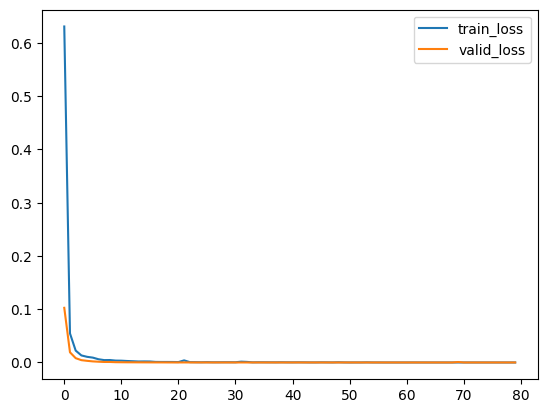

In [15]:
# train_lossとvalid_lossのプロット

plt.plot(grand_train_loss, label="train_loss")
plt.plot(grand_valid_loss, label="valid_loss")
plt.legend()
plt.show()

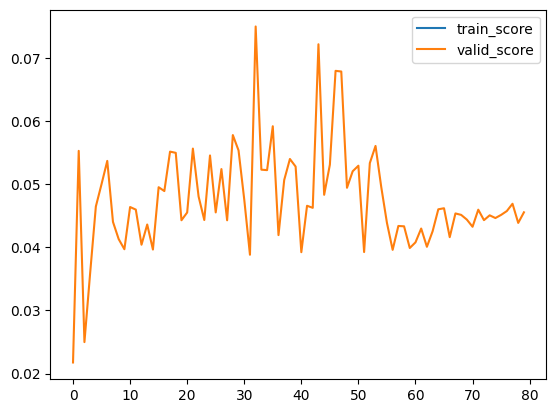

In [16]:
# train_scoreとvalid_scoreのプロット
plt.plot(grand_train_score, label="train_score")
plt.plot(grand_valid_score, label="valid_score")
plt.legend()
plt.show()

In [17]:
normalized_tomogram.shape

torch.Size([1, 16, 64, 64])

In [18]:
x = np.random.randn(1, 16, 1, 320, 320)

x[0, :, 0, :0, :0].shape

(16, 0, 0)

In [19]:
normalized_tomogram = data["normalized_tomogram"]
segmentation_map = data["segmentation_map"]